# Cleaning Subway Data

This notebook details the process of cleaning and joining data for the NYC Subway Canvas assignment.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np
%matplotlib inline

First, I bring in the list of stations, provided from the MTA website. The data lists the stop name, subway line, borough, and latitude and longitude coordinates. I will eventually need to use the stop name to match the ridership data to the station locations.

In [2]:
stations = pd.read_csv('Stations.csv')
stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575


I'll now bring in the Gini Coefficient and Children datasets:

In [4]:
inequality = pd.read_csv('GiniIndex.csv')
inequality.columns = ['geoid','zipcode','ginicoeff','error'] #identified from the dataset's metadata file

inequality.tail()

,geoid,zipcode,ginicoeff,error
235,86000US11691,11691,0.4825,0.0165
236,86000US11692,11692,0.4668,0.0326
237,86000US11693,11693,0.4462,0.0317
238,86000US11694,11694,0.4662,0.0285
239,86000US11697,11697,0.3946,0.0311


In [6]:
children = pd.read_csv('Children.csv')

childreninhouseholds = children[['name', 'B09001002']].copy() #make new df with zip code and # children in households
childreninhouseholds.columns=['zipcode','in_households'] #rename columns
childreninhouseholds = childreninhouseholds.drop(childreninhouseholds.index[0]) #remove All NY row
childreninhouseholds = childreninhouseholds.loc[childreninhouseholds['in_households']!=0] #drop zeroes

childreninhouseholds.tail()

,zipcode,in_households
236,11691,19086
237,11692,5236
238,11693,2399
239,11694,4447
240,11697,1054


I need to normalize the children data (and eventually, station ridership) in order to combine with Gini coefficient because of the different variance for each value. Once normalized, I will multiply the three values to obtain a 'canvassing factor' that encompasses economic inequality, the relative number of children in households, and station ridership to rank the stations in terms of canvassability.

In [7]:
maxvalue = childreninhouseholds['in_households'].max()
minvalue = childreninhouseholds['in_households'].min()

childreninhouseholds['number_kids_normed']=childreninhouseholds['in_households'].apply(
    lambda x: (x-minvalue)/(maxvalue-minvalue))
childreninhouseholds = childreninhouseholds.sort_values(by=['number_kids_normed'], ascending=False).reset_index()
childreninhouseholds['zipcode'] = childreninhouseholds['zipcode'].apply(pd.to_numeric)
childreninhouseholds.head()

,index,zipcode,in_households,number_kids_normed
0,159,11219,34018,1.000000
1,194,11368,29088,0.854025
2,102,10456,27207,0.798330
3,148,11208,26492,0.777159
4,113,10467,26279,0.770852


Since the Gini Coefficient and Children in Household datasets are listed by zipcode, I will bring in a fourth dataset of zip codes (obtained from https://www.gaslampmedia.com/download-zip-code-latitude-longitude-city-state-county-csv/) listed by longitude and latitude coordinates to approximate a zip code for each station, allowing me to join all three datasets. Spot checking for several sets of coordinates and their zip codes using google maps, the dataset seems to be fairly accurate for the New York Area.

In [8]:
zipcodes = pd.read_csv('zip_codes_states.csv')
zipcodes = zipcodes[(zipcodes['state']=='NY')].reset_index() #select only zipcodes from the dataset in New York
zipcodes.tail()

,index,zip_code,latitude,longitude,city,state,county
2228,5809,14902,42.147285,-76.750888,Elmira,NY,Chemung
2229,5810,14903,42.119824,-76.887659,Elmira,NY,Chemung
2230,5811,14904,42.061824,-76.823678,Elmira,NY,Chemung
2231,5812,14905,42.093574,-76.844329,Elmira,NY,Chemung
2232,5813,14925,42.147285,-76.750888,Elmira,NY,Chemung


To approximate the zip code for each station, I'll use the Haversine formula to compute the distance between each subway stop coordinates and each of the listed zip code coordinates. The minimum distance will then be the closest zip code to the subway stop.

In [9]:
stations['distance']=""
stations['zipcode']=""
stations.tail()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,distance,zipcode
488,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,,
489,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,,
490,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,,
491,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,,
492,523,523,S11,SIR,Staten Island,Arthur Kill,SI,SIR,At Grade,40.516578,-74.242096,,


In [10]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between two locations in km """
    # convert dec deg to radians 
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    km = 6367 * c
    return km

In [11]:
def find_distance(stationrow,ziprow):
    """Function to apply haversine to station coordinates and zipcode coordinates"""
    return(haversine(stationrow['GTFS Longitude'],stationrow['GTFS Latitude'],
                               ziprow['longitude'],ziprow['latitude']))

In [12]:
for index, row in stations.iterrows(): #iterrate through all subway stops
    distances = [] #create empty list for distances values
    
    for i,r in zipcodes.iterrows(): #iterrate through all listed zip code locations
        distances.append(find_distance(row,r)) #add computer haversine distance to list
    
    mindistance = min(distances) #find minimum distance between stop and zip code
    ziprownumber = distances.index(mindistance) #take index of shortest distance from distances list
    
    stations.set_value(index,'distance',mindistance) #set minimum distance value 
    stations.set_value(index,'zipcode',zipcodes['zip_code'][ziprownumber]) #fetch zipcode of minimum distance

stations.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,distance,zipcode
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,0.318094,11105
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,0.618813,11102
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,0.544453,11102
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,0.48041,11106
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,0.438293,11106


In [13]:
stations['zipcode'].value_counts() #check stations have been assigned a zip code

11207    17
10013    11
11217    11
11101    10
11204    10
11211     9
11201     9
11237     8
11233     7
11215     7
10467     7
11235     6
11238     6
11230     6
11228     6
10453     6
10002     6
10011     6
10020     5
11372     5
10452     5
10459     5
10455     5
11221     5
11220     5
10451     5
10034     5
11421     5
10305     4
10460     4
         ..
10469     1
11379     1
11374     1
10009     1
11229     1
11105     1
10466     1
10103     1
10471     1
10001     1
10174     1
10095     1
10014     1
10105     1
10016     1
10122     1
11385     1
10019     1
10168     1
10048     1
10022     1
10165     1
10106     1
10154     1
11354     1
11431     1
10199     1
10038     1
11414     1
10153     1
Name: zipcode, dtype: int64

Now, I am ready to merge the Gini coefficient data with household # of children data, and then merge with the stations dataframe on zipcode.

In [16]:
joineddf = pd.merge(inequality, childreninhouseholds, on='zipcode',how='outer')
joineddf = joineddf.dropna(subset=['in_households'],how='all')
bigdf = pd.merge(stations,joineddf, on='zipcode',how='left')
bigdf.head(15)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,distance,zipcode,geoid,ginicoeff,error,index,in_households,number_kids_normed
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,0.318094,11105,86000US11105,0.4302,0.0177,139.0,5760.0,0.163296
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,0.618813,11102,86000US11102,0.4599,0.0172,136.0,5541.0,0.156812
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,0.544453,11102,86000US11102,0.4599,0.0172,136.0,5541.0,0.156812
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,0.48041,11106,86000US11106,0.4696,0.0214,140.0,5489.0,0.155272
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,0.438293,11106,86000US11106,0.4696,0.0214,140.0,5489.0,0.155272
5,6,6,R08,BMT,Astoria,39 Av,Q,N W,Elevated,40.752882,-73.932755,0.870633,11106,86000US11106,0.4696,0.0214,140.0,5489.0,0.155272
6,7,613,R11,BMT,Astoria,Lexington Av/59 St,M,N W R,Subway,40.762660,-73.967258,0.184895,10155,NaN,NaN,NaN,NaN,NaN,NaN
7,8,8,R13,BMT,Astoria,5 Av/59 St,M,N W R,Subway,40.764811,-73.973347,0.0833213,10153,NaN,NaN,NaN,NaN,NaN,NaN
8,9,9,R14,BMT,Broadway - Brighton,57 St - 7 Av,M,N Q R W,Subway,40.764664,-73.980658,0.0669528,10106,NaN,NaN,NaN,NaN,NaN,NaN
9,10,10,R15,BMT,Broadway - Brighton,49 St,M,N R W,Subway,40.759901,-73.984139,0.370881,10112,NaN,NaN,NaN,NaN,NaN,NaN


Many of the zipcodes did not have Gini coeff or household children data, so I will remove these entries and clean out columns that I will not be using.

In [17]:
bigdf = bigdf.dropna(subset=['ginicoeff'],how='all')
bigdf = bigdf.dropna(subset=['in_households'],how='all')
bigdf = bigdf.dropna(subset=['Stop Name'],how='all')
bigdf.tail(15)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,distance,zipcode,geoid,ginicoeff,error,index,in_households,number_kids_normed
478,507,507,S25,SIR,Staten Island,Dongan Hills,SI,SIR,Embankment,40.588849,-74.096090,1.77723,10305,86000US10305,0.4309,0.0187,88.0,8918.0,0.256803
479,508,508,S24,SIR,Staten Island,Jefferson Av,SI,SIR,Embankment,40.583591,-74.103338,2.60664,10305,86000US10305,0.4309,0.0187,88.0,8918.0,0.256803
480,509,509,S23,SIR,Staten Island,Grant City,SI,SIR,Open Cut,40.578965,-74.109704,2.39765,10306,86000US10306,0.4384,0.0149,89.0,11135.0,0.322447
481,510,510,S22,SIR,Staten Island,New Dorp,SI,SIR,Open Cut,40.573480,-74.117210,1.5964,10306,86000US10306,0.4384,0.0149,89.0,11135.0,0.322447
482,511,511,S21,SIR,Staten Island,Oakwood Heights,SI,SIR,Open Cut,40.565110,-74.126320,0.688965,10306,86000US10306,0.4384,0.0149,89.0,11135.0,0.322447
483,512,512,S20,SIR,Staten Island,Bay Terrace,SI,SIR,Embankment,40.556400,-74.136907,1.16586,10308,86000US10308,0.3996,0.0255,91.0,5475.0,0.154857
484,513,513,S19,SIR,Staten Island,Great Kills,SI,SIR,Open Cut,40.551231,-74.151399,0.211642,10308,86000US10308,0.3996,0.0255,91.0,5475.0,0.154857
485,514,514,S18,SIR,Staten Island,Eltingville,SI,SIR,Embankment,40.544601,-74.164570,0.857017,10312,86000US10312,0.4045,0.0152,95.0,13230.0,0.384479
486,515,515,S17,SIR,Staten Island,Annadale,SI,SIR,Open Cut,40.540460,-74.178217,0.60145,10312,86000US10312,0.4045,0.0152,95.0,13230.0,0.384479
487,516,516,S16,SIR,Staten Island,Huguenot,SI,SIR,Open Cut,40.533674,-74.191794,1.92767,10312,86000US10312,0.4045,0.0152,95.0,13230.0,0.384479


In [18]:
stationdf = bigdf.drop([
        'Station ID','Complex ID','Division','Daytime Routes','Structure','geoid','error','index'], axis=1)
stationdf = stationdf.dropna(subset=['GTFS Latitude','GTFS Longitude'],how='all').reset_index()
stationdf.tail(10)

,index,GTFS Stop ID,Line,Stop Name,Borough,GTFS Latitude,GTFS Longitude,distance,zipcode,ginicoeff,in_households,number_kids_normed
429,483,S20,Staten Island,Bay Terrace,SI,40.556400,-74.136907,1.16586,10308,0.3996,5475.0,0.154857
430,484,S19,Staten Island,Great Kills,SI,40.551231,-74.151399,0.211642,10308,0.3996,5475.0,0.154857
431,485,S18,Staten Island,Eltingville,SI,40.544601,-74.164570,0.857017,10312,0.4045,13230.0,0.384479
432,486,S17,Staten Island,Annadale,SI,40.540460,-74.178217,0.60145,10312,0.4045,13230.0,0.384479
433,487,S16,Staten Island,Huguenot,SI,40.533674,-74.191794,1.92767,10312,0.4045,13230.0,0.384479
434,488,S15,Staten Island,Prince's Bay,SI,40.525507,-74.200064,1.72704,10309,0.4286,8013.0,0.230006
435,489,S14,Staten Island,Pleasant Plains,SI,40.522410,-74.217847,1.04277,10309,0.4286,8013.0,0.230006
436,490,S13,Staten Island,Richmond Valley,SI,40.519631,-74.229141,1.46597,10307,0.4217,3769.0,0.104344
437,491,S09,Staten Island,Tottenville,SI,40.512764,-74.251961,0.876482,10307,0.4217,3769.0,0.104344
438,492,S11,Staten Island,Arthur Kill,SI,40.516578,-74.242096,0.650771,10307,0.4217,3769.0,0.104344


After cleaning out the stations dataframe, I now have to join this data with the station traffic data using the station name. I will use Gabriel's station name processing steps to make the station names the same in both my dataframes.

In [23]:
stationdf['Stop Name'] = stationdf['Stop Name'].str.upper()
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace(' AV', ' AVE')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace(' AVEE', ' AVE')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('AVENUE', 'AVE')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('-', ' - ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('/', ' - ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('0 ', '0th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('1 ', '1st ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('11st', '11th')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('2 ', '2nd ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('12nd', '12th')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('3 ', '3rd ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('13rd', '13th')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('4 ', '4th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('5 ', '5th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('6 ', '6th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('7 ', '7th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('8 ', '8th ')
stationdf['Stop Name'] = stationdf['Stop Name'].str.replace('9 ', '9th ')
stationdf.head()

,index,GTFS Stop ID,Line,Stop Name,Borough,GTFS Latitude,GTFS Longitude,distance,zipcode,ginicoeff,in_households,number_kids_normed
0,0,R01,Astoria,ASTORIA - DITMARS BLVD,Q,40.775036,-73.912034,0.318094,11105,0.4302,5760.0,0.163296
1,1,R03,Astoria,ASTORIA BLVD,Q,40.770258,-73.917843,0.618813,11102,0.4599,5541.0,0.156812
2,2,R04,Astoria,30TH AVE,Q,40.766779,-73.921479,0.544453,11102,0.4599,5541.0,0.156812
3,3,R05,Astoria,BROADWAY,Q,40.761820,-73.925508,0.48041,11106,0.4696,5489.0,0.155272
4,4,R06,Astoria,36TH AVE,Q,40.756804,-73.929575,0.438293,11106,0.4696,5489.0,0.155272


Here, I bring in the station ridership data set and normalize the most recent (2014) ridership values.

In [24]:
annual_ridership = pd.read_csv('mta_annual_subway_ridership.csv.txt')
maxvalue = annual_ridership['2014'].max()
minvalue = annual_ridership['2014'].min()
annual_ridership['2014_normed']=annual_ridership['2014'].apply(
    lambda x: (x-minvalue)/(maxvalue-minvalue))
annual_ridership = annual_ridership.sort_values(by=['2014 Rank'], ascending=True)
annual_ridership.head()

,Borough,Station,2009,2010,2011,2012,2013,2014,∆,∆%,2014 Rank,2014_normed
339,Manhattan,Times Sq-42 St /42 St,58099313,58422597,60604822,62069437,63617614,65948730,2331116.0,3.70%,1.0,1.000000
323,Manhattan,Grand Central-42 St,42002971,41903210,42795505,42984249,44893301,46074652,1181351.0,2.60%,2.0,0.698644
271,Manhattan,34 St-Herald Square,36945680,37769752,37731386,37154138,38213448,39285568,1072120.0,2.80%,3.0,0.595699
243,Manhattan,14 St-Union Sq,34245245,34730692,34927178,34639575,35309414,35677468,368054.0,1%,4.0,0.540988
272,Manhattan,34 St-Penn Station,27196195,26892243,26758623,27010176,27730331,28638643,908312.0,3.30%,5.0,0.434256


Then, I apply the same string processing steps fo the Station column so that the join on name will eventually match.

In [25]:
annual_ridership['Station'] = annual_ridership['Station'].str.upper()
annual_ridership['Station'] = annual_ridership['Station'].str.replace(' AV', ' AVE')
annual_ridership['Station'] = annual_ridership['Station'].str.replace(' AVEE', ' AVE')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('AVENUE', 'AVE')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('-', ' - ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('/', ' - ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('0 ', '0th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('1 ', '1st ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('11st', '11th')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('2 ', '2nd ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('12nd', '12th')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('3 ', '3rd ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('13rd', '13th')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('4 ', '4th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('5 ', '5th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('6 ', '6th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('7 ', '7th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('8 ', '8th ')
annual_ridership['Station'] = annual_ridership['Station'].str.replace('9 ', '9th ')
annual_ridership.head()

,Borough,Station,2009,2010,2011,2012,2013,2014,∆,∆%,2014 Rank,2014_normed
339,Manhattan,TIMES SQ - 42nd ST - 42nd ST,58099313,58422597,60604822,62069437,63617614,65948730,2331116.0,3.70%,1.0,1.000000
323,Manhattan,GRAND CENTRAL - 42nd ST,42002971,41903210,42795505,42984249,44893301,46074652,1181351.0,2.60%,2.0,0.698644
271,Manhattan,34th ST - HERALD SQUARE,36945680,37769752,37731386,37154138,38213448,39285568,1072120.0,2.80%,3.0,0.595699
243,Manhattan,14th ST - UNION SQ,34245245,34730692,34927178,34639575,35309414,35677468,368054.0,1%,4.0,0.540988
272,Manhattan,34th ST - PENN STATION,27196195,26892243,26758623,27010176,27730331,28638643,908312.0,3.30%,5.0,0.434256


In [26]:
station_names_map = {
    '103rd ST - CORONA': '103rd St - Corona Plaza',
    '116th ST - COLUMBIA': '116th St - Columbia University',
    '137th ST CITY COL': '137th St - City College',
    '138th - GRAND CONC': '138th St - Grand Concourse',
    '149th - GRAND CONC': '149th St - Grand Concourse',
    '14TH STREET': '14th St',
    '14th ST - UNION SQ': 'Union Sq - 14th St',
    '15th ST - PROSPECT': '15th St - Prospect Park',
    '161st - YANKEE STAD': '161st St - Yankee Stadium',
    '163rd ST - AMSTERDM': '163rd St - Amsterdam Av',
    '174th - 175th STS': '174th-175th Sts',
    '182nd - 183rd STS': '182nd-183rd Sts',
    '21st ST - QNSBRIDGE': '21st St - Queensbridge',
    '2nd AVE': 'Lower East Side - 2nd Ave',
    '3rd AVE 138th ST': '3rd Ave - 138th St',
    '34th ST - HERALD SQ': 'Herald Sq - 34th St',
    '34th ST - HUDSON YD': '34th St - Hudson Yards',
    '34th ST - PENN STA': '34th St - Penn Station',
    '4th AVE - 9th ST': '4th Av - 9th St',
    '40th ST LOWERY ST': '40th St',
    '42nd ST - PORT AUTH': '42nd St - Port Authority Bus Term',
    '47th - 50th STS ROCK': '47th-50th Sts - Rockefeller Ctr',
    '4AV - 9th ST': '4th Av - 9th St',
    '5th AVE': '5th Ave - Bryant Pk',
    '59th ST COLUMBUS': '59th St - Columbus Circle',
    '61st ST WOODSIDE': 'Woodside - 61st St',
    '66th ST - LINCOLN': '66th St - Lincoln Ctr',
    '68ST - HUNTER CO': '68th St - Hunter College',
    '75th ST - ELDERTS': '75th St - Eldert Ln',
    '81st ST - MUSEUM': '81st St',
    '82nd ST - JACKSON H': '82nd St - Jackson Hts',
    '85th ST - FOREST PK': '85th St - Forest Pky',
    '90th ST - ELMHURST': '90th St - Elmhurst Av',
    'AQUEDUCT N.COND': 'Aqueduct - North Conduit Av',
    'AQUEDUCT RACETR': 'Aqueduct Racetrack',
    'ASTORIA DITMARS': 'Astoria - Ditmars Blvd',
    'ATL AVE - BARCLAY': "Atlantic Av - Barclay's Center",
    "B'WAY - LAFAYETTE": 'Broadway - Lafayette St',
    'BAY PKWY': 'Bay Pky',
    'BEDFORD PK BLVD': 'Bedford Park Blvd',
    'BEDFORD - NOSTRAN': 'Bedford - Nostrand Aves',
    'BEVERLEY ROAD': 'Beverly Rd',
    'BRIARWOOD': 'Briarwood - Van Wyck Blvd',
    'BROADWAY JCT': 'Broadway Junction',
    'BROOKLYN BRIDGE': 'Brooklyn Bridge - City Hall',
    'BUSHWICK AVE': 'Bushwick - Aberdeen',
    'CANARSIE - ROCKAW': 'Canarsie - Rockaway Pkwy',
    'CATHEDRAL PKWY': 'Cathedral Pkwy (110th St)',
    'CENTRAL PK N110': 'Central Park North (110th St)',
    'CHRISTOPHER ST': 'Christopher St - Sheridan Sq',
    'CLINTON - WASH AVE': 'Clinton - Washington Aves',
    'CONEY IS - STILLW': 'Coney Island - Stillwell Av',
    'CROWN HTS - UTICA': 'Crown Hts - Utica Ave',
    'DELANCEY - ESSEX': 'Delancey St - Essex St',
    "E 143rd - ST MARY'S": "E 143rd St - St Mary's St",
    'EASTCHSTER - DYRE': 'Eastchester - Dyre Ave',
    'EASTN PKWY - MUSM': 'Eastern Pkwy - Bklyn Museum',
    'EAST 105th ST': 'E 105th St',
    'FAR ROCKAWAY': 'Far Rockaway - Mott Ave',
    'FLATBUSH AVE - B.C': 'Brooklyn College - Flatbush Ave',
    'FLUSHING - MAIN': 'Flushing - Main St',
    'FOREST HILLS 71': 'Forest Hills - 71st Av',
    'FT HAMILTON PKY': 'Ft Hamilton Pkwy',
    'GRAND ARMY PLAZ': 'Grand Army Plaza',
    'GRAND - NEWTOWN': 'Grand Ave - Newtown',
    'GRD CNTRL - 42nd ST': 'Grand Central - 42nd St',
    'HARLEM 148th ST': 'Harlem - 148 St',
    'HOWARD BCH JFK': 'Howard Beach - JFK Airport',
    'HOYT - SCHER': 'Hoyt - Schermerhorn Sts',
    'HUNTERS PT AVE': 'Hunters Point Ave',
    'JAMAICA 179th ST': 'Jamaica - 179th St',
    'JAMAICA CENTER': 'Jamaica Ctr - Parsons / Archer',
    'JAMAICA VAN WK': 'Jamaica - Van Wyck',
    'JAY ST - METROTEC': 'Jay St - MetroTech',
    'JKSN HT - ROOSVLT': 'Jackson Hts - Roosevelt Av',
    'KEW GARDENS': 'Kew Gardens - Union Tpke',
    'KINGSTON - THROOP': 'Kingston - Throop Aves',
    'KNICKERBOCKER': 'Knickerbocker Ave',
    'LEXINGTON AVE - 53': 'Lexington Ave - 53rd St',
    'LEXINGTON AVE - 63': 'Lexington Ave - 63rd St',
    'MARBLE HILL - 225': 'Marble Hill - 225th St',
    'METS - WILLETS PT': 'Mets - Willets Point',
    'MORISN AVE - SNDVW': 'Morrison Av - Soundview',
    'MYRTLE - WILLOUGH': 'Myrtle-Willoughby Aves',
    'MYRTLE - WYCKOFF': 'Myrtle - Wyckoff Aves',
    'NASSAU ST': 'Nassau Ave',
    'NEREID AVE': 'Nereid Ave (238 St)',
    'MYRTLE - WILLOUGH': 'Myrtle-Willoughby Aves',
    'MYRTLE - WYCKOFF': 'Myrtle - Wyckoff Aves',
    'NEREID AVE': 'Nereid Ave (238 St)',
    'NORWOOD 205th ST': 'Norwood - 205th St',
    'OZONE PK LEFFRT': 'Ozone Park - Lefferts Blvd',
    'PARK PLACE': 'Park Pl',
    'QUEENS PLAZA': 'Queens Plz',
    'ROCKAWAY PARK B': 'Rockaway Park - Beach 116 St',
    'ROOSEVELT ISLND': 'Roosevelt Island - Main St',
    'SMITH - 9th ST': 'Smith - 9th Sts',
    'SUTPHIN - ARCHER': 'Sutphin Blvd - Archer Av',
    'SUTTER AVE - RUTLD': 'Sutter Ave - Rutland Road',
    'V.CORTLANDT PK': 'Van Cortlandt Park - 242nd St',
    'VERNON - JACKSON': 'Vernon Blvd - Jackson Ave',
    'W 4th ST - WASH SQ': 'W 4th St - Washington Sq (Upper)',
    'W 8th ST - AQUARIUM': 'W 8th St - NY Aquarium',
    'WAKEFIELD - 241': 'Wakefield - 241st St',
    'WEST FARMS SQ': 'West Farms Sq - E Tremont Av',
    'WESTCHESTER SQ': 'Westchester Sq - E Tremont Ave',
    'WHITEHALL S - FRY': 'Whitehall St',
    'WORLD TRADE CTR': 'World Trade Center'
}

for i, station_name in annual_ridership['Station'].iteritems():
    if station_name in station_names_map.keys():
        better_name = station_names_map.get(station_name)
        annual_ridership.set_value(i, 'Station', better_name)

for i, station_name in stationdf['Stop Name'].iteritems():
    if station_name in station_names_map.keys():
        better_name = station_names_map.get(station_name)
        stationdf.set_value(i, 'Stop Name', better_name)


annual_ridership.head(20)

,Borough,Station,2009,2010,2011,2012,2013,2014,∆,∆%,2014 Rank,2014_normed
339,Manhattan,TIMES SQ - 42nd ST - 42nd ST,58099313,58422597,60604822,62069437,63617614,65948730,2331116.0,3.70%,1.0,1.000000
323,Manhattan,GRAND CENTRAL - 42nd ST,42002971,41903210,42795505,42984249,44893301,46074652,1181351.0,2.60%,2.0,0.698644
271,Manhattan,34th ST - HERALD SQUARE,36945680,37769752,37731386,37154138,38213448,39285568,1072120.0,2.80%,3.0,0.595699
243,Manhattan,Union Sq - 14th St,34245245,34730692,34927178,34639575,35309414,35677468,368054.0,1%,4.0,0.540988
272,Manhattan,34th ST - PENN STATION,27196195,26892243,26758623,27010176,27730331,28638643,908312.0,3.30%,5.0,0.434256
273,Manhattan,34th ST - PENN STATION,24182097,24265016,24751771,24851746,25726374,26493571,767197.0,3%,6.0,0.401730
283,Manhattan,59th ST - COLUMBUS CIRCLE,20418815,20711058,21300892,21599586,22774421,23566961,792540.0,3.50%,7.0,0.357353
328,Manhattan,LEXINGTON AVE - 59th ST,18924005,19553597,20377141,20628942,21282767,21557198,274431.0,1.30%,8.0,0.326878
294,Manhattan,86th ST,18891890,19147021,19425347,19686985,20528208,20735032,206824.0,1%,9.0,0.314411
329,Manhattan,LEXINGTON AVE - 53rd ST - 51st ST,18618358,18025148,18948032,19280036,20262110,20513370,251260.0,1.20%,10.0,0.311050


In [27]:
annual_ridership['join_name'] = annual_ridership['Station'].str.lower()
stationdf['join_name'] = stationdf['Stop Name'].str.lower()
stationdf['join_name'].value_counts()

canal st                             6
23rd st                              5
125th st                             4
86th st                              4
96th st                              4
franklin ave                         3
court sq                             3
111th st                             3
times sq    -    42nd st             3
fort hamilton pkwy                   3
chambers st                          3
ave u                                3
bay pky                              3
atlantic ave    -    barclays ctr    3
116th st                             3
18th ave                             3
145th st                             3
kings hwy                            3
72nd st                              3
103rd st                             3
van siclen ave                       3
broadway junction                    3
46th st                              2
broadway                             2
nostrand ave                         2
rector st                

In order to merge the ridership data with the Gini coefficient/children in households data (stationdf), I will separate both dataframes by borough, to avoid most of the cases where there are multiple stations with the same name. Where there are multiple stations within the same borough, I will use the first value when sorting on ridership rank and remove duplicates, using the one with the highest ridership, since it is most likely to be a candidate for canvassing.

In [49]:
annual_ridership = annual_ridership.drop(['2009','2010','2011','2012','2013','∆','∆%'],axis=1)

queens_ridership = annual_ridership[annual_ridership['Borough']=='Queens']
queens_ridership = queens_ridership.drop_duplicates(subset='Station',keep='first').reset_index()

bronx_ridership = annual_ridership[annual_ridership['Borough']=='The Bronx']
bronx_ridership = bronx_ridership.drop_duplicates(subset='Station',keep='first').reset_index()

brooklyn_ridership = annual_ridership[annual_ridership['Borough']=='Brooklyn']
brooklyn_ridership = brooklyn_ridership.drop_duplicates(subset='Station',keep='first').reset_index()

manhattan_ridership = annual_ridership[annual_ridership['Borough']=='Manhattan']
manhattan_ridership = manhattan_ridership.drop_duplicates(subset='Station',keep='first').reset_index()

bronx_ridership.head()

,index,Borough,Station,2014,2014 Rank,2014_normed,join_name
0,2,The Bronx,161st ST - YANKEE STADIUM,8961029,38.0,0.135879,161st st - yankee stadium
1,18,The Bronx,3rd AVE - 149th ST,7763151,54.0,0.117715,3rd ave - 149th st
2,53,The Bronx,PARKCHESTER,5586943,79.0,0.084716,parkchester
3,1,The Bronx,149th ST - GRAND CONCOURSE,4536888,108.0,0.068794,149th st - grand concourse
4,36,The Bronx,FORDHAM RD,4028205,122.0,0.061081,fordham rd


In [50]:
queens_stations = stationdf[stationdf['Borough']=='Q'].reset_index()
bronx_stations = stationdf[stationdf['Borough']=='Bx'].reset_index()
brooklyn_stations = stationdf[stationdf['Borough']=='Bk'].reset_index()
manhattan_stations = stationdf[stationdf['Borough']=='M'].reset_index()
manhattan_stations.head()

,level_0,index,GTFS Stop ID,Line,Stop Name,Borough,GTFS Latitude,GTFS Longitude,distance,zipcode,ginicoeff,in_households,number_kids_normed,join_name
0,6,13,R19,Broadway - Brighton,23RD ST,M,40.741303,-73.989344,0.550255,10010,0.5246,2269.0,0.059930,23rd st
1,7,15,R21,Broadway - Brighton,8TH ST - NYU,M,40.730328,-73.992629,0.160233,10012,0.5081,2041.0,0.053179,8th st - nyu
2,8,16,R22,Broadway - Brighton,PRINCE ST,M,40.724329,-73.997702,0.547054,10013,0.6651,4300.0,0.120066,prince st
3,9,17,R23,Broadway,CANAL ST,M,40.719527,-74.001775,0.321099,10013,0.6651,4300.0,0.120066,canal st
4,10,18,Q01,Manhattan Bridge,CANAL ST,M,40.718383,-74.000460,0.486309,10013,0.6651,4300.0,0.120066,canal st


In [52]:
queens_merged = pd.merge(queens_stations, queens_ridership, how='left', left_on='join_name',
                           right_on='join_name')
bronx_merged = pd.merge(bronx_stations, bronx_ridership, how='left', left_on='join_name',
                           right_on='join_name')
brooklyn_merged = pd.merge(brooklyn_stations, brooklyn_ridership, how='left', left_on='join_name',
                           right_on='join_name')
manhattan_merged = pd.merge(manhattan_stations, manhattan_ridership, how='left', left_on='join_name',
                           right_on='join_name')
manhattan_merged.tail(20)

,level_0,index_x,GTFS Stop ID,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,distance,zipcode,ginicoeff,in_households,number_kids_normed,join_name,index_y,Borough_y,Station,2014,2014 Rank,2014_normed
83,354,401,632,Lexington - Shuttle,33RD ST,M,40.746081,-73.982076,0.311501,10016,0.5137,4407.0,0.123235,33rd st,270.0,Manhattan,33rd ST,9798598.0,33.0,0.148579
84,355,402,633,Lexington - Shuttle,28TH ST,M,40.743070,-73.984264,0.453703,10010,0.5246,2269.0,0.059930,28th st,267.0,Manhattan,28th ST,7107083.0,61.0,0.107767
85,356,403,634,Lexington - Shuttle,23RD ST,M,40.739864,-73.986599,0.273796,10010,0.5246,2269.0,0.059930,23rd st,262.0,Manhattan,23rd ST,9033835.0,37.0,0.136983
86,357,404,635,Lexington - Shuttle,14TH ST - UNION SQ,M,40.734673,-73.989951,0.508112,10003,0.5503,3485.0,0.095935,14th st - union sq,NaN,NaN,NaN,NaN,NaN,NaN
87,358,405,636,Lexington - Shuttle,ASTOR PL,M,40.730054,-73.991070,0.11198,10012,0.5081,2041.0,0.053179,astor pl,NaN,NaN,NaN,NaN,NaN,NaN
88,359,406,637,Lexington - Shuttle,BLEECKER ST,M,40.725915,-73.994659,0.440805,10012,0.5081,2041.0,0.053179,bleecker st,NaN,NaN,NaN,NaN,NaN,NaN
89,360,407,638,Lexington - Shuttle,SPRING ST,M,40.722301,-73.997141,0.535743,10013,0.6651,4300.0,0.120066,spring st,337.0,Manhattan,SPRING ST,4169799.0,119.0,0.063228
90,361,408,639,Lexington - Shuttle,CANAL ST,M,40.718803,-74.000193,0.460516,10013,0.6651,4300.0,0.120066,canal st,307.0,Manhattan,CANAL ST,15104077.0,18.0,0.229028
91,362,409,640,Lexington - Shuttle,BROOKLYN BRIDGE - CITY HALL,M,40.713065,-74.004131,0.292131,10007,0.5017,1282.0,0.030705,brooklyn bridge - city hall,NaN,NaN,NaN,NaN,NaN,NaN
92,384,434,301,Lenox - White Plains Rd,HARLEM - 148TH ST,M,40.823880,-73.936470,0.40168,10039,0.5315,6606.0,0.188346,harlem - 148th st,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
queens_merged = queens_merged.dropna(subset=['2014'],how='all')
queens_merged = queens_merged.drop([
        'level_0','index_x','distance','index_y','Borough_y','Station'], axis=1)

bronx_merged = bronx_merged.dropna(subset=['2014'],how='all')
bronx_merged = bronx_merged.drop([
        'level_0','index_x','distance','index_y','Borough_y','Station'], axis=1)

brooklyn_merged = brooklyn_merged.dropna(subset=['2014'],how='all')
brooklyn_merged = brooklyn_merged.drop([
        'level_0','index_x','distance','index_y','Borough_y','Station'], axis=1)

manhattan_merged = manhattan_merged.dropna(subset=['2014'],how='all')
manhattan_merged = manhattan_merged.drop([
        'level_0','index_x','distance','index_y','Borough_y','Station'], axis=1)

In [54]:
manhattan_merged.tail()

,GTFS Stop ID,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,zipcode,ginicoeff,in_households,number_kids_normed,join_name,2014,2014 Rank,2014_normed
95,225,Lenox - White Plains Rd,125TH ST,M,40.807754,-73.945495,10027,0.5786,12203.0,0.354070,125th st,9574765.0,34.0,0.145185
96,226,Lenox - White Plains Rd,116TH ST,M,40.802098,-73.949625,10026,0.5719,7918.0,0.227193,116th st,5370343.0,85.0,0.081432
100,Q05,Second Av,96TH ST,M,40.784318,-73.947152,10128,0.5610,9645.0,0.278329,96th st,13108304.0,23.0,0.198765
101,Q04,Second Av,86TH ST,M,40.777891,-73.951787,10028,0.5659,6859.0,0.195837,86th st,20735032.0,9.0,0.314411
102,Q03,Second Av,72ND ST,M,40.768799,-73.958424,10021,0.5812,7018.0,0.200545,72nd st,13375012.0,22.0,0.202809


Now, I am fianlly ready to calculate the canvassing factor:

In [55]:
queens_merged['canvas_factor'] = (queens_merged['ginicoeff']*
    queens_merged['number_kids_normed']*queens_merged['2014_normed'])
bronx_merged['canvas_factor'] = (bronx_merged['ginicoeff']*
    bronx_merged['number_kids_normed']*bronx_merged['2014_normed'])
brooklyn_merged['canvas_factor'] = (brooklyn_merged['ginicoeff']*
    brooklyn_merged['number_kids_normed']*brooklyn_merged['2014_normed'])
manhattan_merged['canvas_factor'] = (manhattan_merged['ginicoeff']*
    manhattan_merged['number_kids_normed']*manhattan_merged['2014_normed'])

In [56]:
manhattan_merged.head()

,GTFS Stop ID,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,zipcode,ginicoeff,in_households,number_kids_normed,join_name,2014,2014 Rank,2014_normed,canvas_factor
0,R19,Broadway - Brighton,23RD ST,M,40.741303,-73.989344,10010,0.5246,2269.0,0.059930,23rd st,9033835.0,37.0,0.136983,0.004307
2,R22,Broadway - Brighton,PRINCE ST,M,40.724329,-73.997702,10013,0.6651,4300.0,0.120066,prince st,5311765.0,87.0,0.080544,0.006432
3,R23,Broadway,CANAL ST,M,40.719527,-74.001775,10013,0.6651,4300.0,0.120066,canal st,15104077.0,18.0,0.229028,0.018289
4,Q01,Manhattan Bridge,CANAL ST,M,40.718383,-74.000460,10013,0.6651,4300.0,0.120066,canal st,15104077.0,18.0,0.229028,0.018289
5,R24,Broadway,CITY HALL,M,40.713282,-74.006978,10007,0.5017,1282.0,0.030705,city hall,1151646.0,344.0,0.017463,0.000269


In [ ]:
queens_merged = queens_merged.sort_values(by='canvas_factor',ascending=False).reset_index()
bronx_merged = bronx_merged.sort_values(by='canvas_factor',ascending=False).reset_index()
brooklyn_merged = brooklyn_merged.sort_values(by='canvas_factor',ascending=False).reset_index()
manhattan_merged = manhattan_merged.sort_values(by='canvas_factor',ascending=False).reset_index()

In [61]:
queens_merged = queens_merged.drop(['level_0'],axis=1)
queens_merged = queens_merged.drop_duplicates(subset='Stop Name',keep='first').reset_index()

bronx_merged = bronx_merged.drop(['level_0'],axis=1)
bronx_merged = bronx_merged.drop_duplicates(subset='Stop Name',keep='first').reset_index()

brooklyn_merged = brooklyn_merged.drop(['level_0'],axis=1)
brooklyn_merged = brooklyn_merged.drop_duplicates(subset='Stop Name',keep='first').reset_index()

manhattan_merged = manhattan_merged.drop(['level_0'],axis=1)
manhattan_merged = manhattan_merged.drop_duplicates(subset='Stop Name',keep='first').reset_index()
manhattan_merged

,level_0,index,GTFS Stop ID,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,zipcode,ginicoeff,in_households,number_kids_normed,join_name,2014,2014 Rank,2014_normed,canvas_factor
0,0,61,120,Broadway - 7Av,96TH ST,M,40.793919,-73.972323,10025,0.5701,13760.0,0.400172,96th st,13108304.0,23.0,0.198765,0.045346
1,2,101,Q04,Second Av,86TH ST,M,40.777891,-73.951787,10028,0.5659,6859.0,0.195837,86th st,20735032.0,9.0,0.314411,0.034844
2,6,57,116,Broadway - 7Av,125TH ST,M,40.815581,-73.958372,10027,0.5786,12203.0,0.354070,125th st,9574765.0,34.0,0.145185,0.029743
3,9,30,A22,8th Av - Fulton St,72ND ST,M,40.775594,-73.976410,10023,0.5611,8470.0,0.243538,72nd st,13375012.0,22.0,0.202809,0.027714
4,11,42,D22,6th Av - Culver,GRAND ST,M,40.718267,-73.993753,10002,0.5705,12113.0,0.351405,grand st,8131543.0,45.0,0.123301,0.024719
5,13,78,624,Lexington - Shuttle,103RD ST,M,40.790600,-73.947478,10029,0.6064,16100.0,0.469458,103rd st,5198601.0,90.0,0.078828,0.022441
6,14,81,627,Lexington - Shuttle,77TH ST,M,40.773620,-73.959874,10021,0.5812,7018.0,0.200545,77th st,11454604.0,28.0,0.173690,0.020245
7,15,3,R23,Broadway,CANAL ST,M,40.719527,-74.001775,10013,0.6651,4300.0,0.120066,canal st,15104077.0,18.0,0.229028,0.018289
8,21,20,A09,8th Av - Fulton St,168TH ST,M,40.840719,-73.939561,10032,0.4817,10639.0,0.307761,168th st,8090476.0,47.0,0.122678,0.018187
9,24,77,623,Lexington - Shuttle,110TH ST,M,40.795020,-73.944250,10029,0.6064,16100.0,0.469458,110th st,3955522.0,125.0,0.059979,0.017075


In order to choose the top 10 stations by canvas factor, I concatenate all of the dataframes for each borough.

In [63]:
merged = [queens_merged,bronx_merged,brooklyn_merged,manhattan_merged]
merged_df = pd.concat(merged)
merged_df = merged_df.sort_values(by='canvas_factor',ascending=False)
targeted_stations = merged_df[:10]
targeted_stations

,level_0,index,GTFS Stop ID,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,zipcode,ginicoeff,in_households,number_kids_normed,join_name,2014,2014 Rank,2014_normed,canvas_factor
0,0,75,L08,Canarsie,BEDFORD AVE,Bk,40.717304,-73.956872,11211,0.5366,24089.0,0.706008,bedford ave,9892516.0,32.0,0.150003,0.056828
0,0,61,120,Broadway - 7Av,96TH ST,M,40.793919,-73.972323,10025,0.5701,13760.0,0.400172,96th st,13108304.0,23.0,0.198765,0.045346
1,2,101,Q04,Second Av,86TH ST,M,40.777891,-73.951787,10028,0.5659,6859.0,0.195837,86th st,20735032.0,9.0,0.314411,0.034844
1,1,27,D35,Broadway - Brighton,KINGS HWY,Bk,40.608670,-73.957734,11230,0.5324,24089.0,0.706008,kings hwy,5693562.0,76.0,0.086333,0.032451
2,6,57,116,Broadway - 7Av,125TH ST,M,40.815581,-73.958372,10027,0.5786,12203.0,0.354070,125th st,9574765.0,34.0,0.145185,0.029743
3,9,30,A22,8th Av - Fulton St,72ND ST,M,40.775594,-73.976410,10023,0.5611,8470.0,0.243538,72nd st,13375012.0,22.0,0.202809,0.027714
0,0,47,G11,Queens - Archer,WOODHAVEN BLVD,Q,40.733106,-73.869229,11373,0.4593,18643.0,0.544755,woodhaven blvd,7125205.0,59.0,0.108042,0.027033
2,4,20,D28,Broadway - Brighton,CHURCH AVE,Bk,40.650527,-73.962982,11226,0.4623,22993.0,0.673556,church ave,5482093.0,80.0,0.083127,0.025884
4,11,42,D22,6th Av - Culver,GRAND ST,M,40.718267,-73.993753,10002,0.5705,12113.0,0.351405,grand st,8131543.0,45.0,0.123301,0.024719
3,6,71,M16,Jamaica,MARCY AVE,Bk,40.708359,-73.957757,11211,0.5366,24089.0,0.706008,marcy ave,3953628.0,126.0,0.059950,0.022712


Plotted against all of the system locations, the locations seem to be distributed around New York City, not concentrated in one borough or neighborhood.

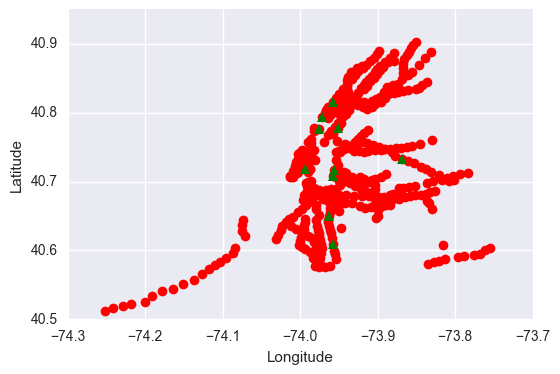

In [70]:
plt.plot(stationdf['GTFS Longitude'],stationdf['GTFS Latitude'], 'ro')
plt.plot(targeted_stations['GTFS Longitude'],targeted_stations['GTFS Latitude'], 'g^')
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig('targetlocations.png')
plt.show()

In [67]:
finaldf = targeted_stations.drop([
        'index',
        'level_0',
        'GTFS Stop ID',
        'join_name',
        '2014',
        '2014 Rank',
        'in_households',
        'number_kids_normed',
        'ginicoeff',
        '2014_normed'], axis=1).reset_index()
finaldf = finaldf.drop(['index'], axis=1)

finaldf

,Line,Stop Name,Borough_x,GTFS Latitude,GTFS Longitude,zipcode,canvas_factor
0,Canarsie,BEDFORD AVE,Bk,40.717304,-73.956872,11211,0.056828
1,Broadway - 7Av,96TH ST,M,40.793919,-73.972323,10025,0.045346
2,Second Av,86TH ST,M,40.777891,-73.951787,10028,0.034844
3,Broadway - Brighton,KINGS HWY,Bk,40.608670,-73.957734,11230,0.032451
4,Broadway - 7Av,125TH ST,M,40.815581,-73.958372,10027,0.029743
5,8th Av - Fulton St,72ND ST,M,40.775594,-73.976410,10023,0.027714
6,Queens - Archer,WOODHAVEN BLVD,Q,40.733106,-73.869229,11373,0.027033
7,Broadway - Brighton,CHURCH AVE,Bk,40.650527,-73.962982,11226,0.025884
8,6th Av - Culver,GRAND ST,M,40.718267,-73.993753,10002,0.024719
9,Jamaica,MARCY AVE,Bk,40.708359,-73.957757,11211,0.022712


In [66]:
import pytablewriter

writer = pytablewriter.MarkdownTableWriter()
writer.table_name = "Station List"
writer.header_list = list(finaldf.columns.values)
writer.value_matrix = finaldf.values.tolist()
writer.write_table()

# Station List
       Line        |  Stop Name   |Borough_x|GTFS Latitude|GTFS Longitude|zipcode|canvas_factor
-------------------|--------------|---------|------------:|-------------:|------:|------------:
Canarsie           |BEDFORD AVE   |Bk       |        40.72|        -73.96|11211|      0.05683
Broadway - 7Av     |96TH ST       |M        |        40.79|        -73.97|10025|      0.04535
Second Av          |86TH ST       |M        |        40.78|        -73.95|10028|      0.03484
Broadway - Brighton|KINGS HWY     |Bk       |        40.61|        -73.96|11230|      0.03245
Broadway - 7Av     |125TH ST      |M        |        40.82|        -73.96|10027|      0.02974
8th Av - Fulton St |72ND ST       |M        |        40.78|        -73.98|10023|      0.02771
Queens - Archer    |WOODHAVEN BLVD|Q        |        40.73|        -73.87|11373|      0.02703
Broadway - Brighton|CHURCH AVE    |Bk       |        40.65|        -73.96|11226|      0.02588
6th Av - Culver    |GRAND ST      |M     